### Import libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package stopwords to C:\Users\Mini
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [11]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df = df.dropna()
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


### Preprocessing texts

In [12]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym 'RT' removal
    text = re.sub(r"^rt[\s]+", "", text)

    # Hyperlinks removal
    text = re.sub(r"https?:\/\/.*[\r\n]*", "", text)

    # Punctuation removal
    text= re.sub(r"[^\w\s]", "", text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Steming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text



In [14]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
intercept = np.ones(
    (X.shape[0], 1)
)

X_b = np.concatenate(
    (intercept, X),
    axis=1
)

print(X_b)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [18]:
n_classes = df['category'].nunique()
print(n_classes)
n_samples = df['category'].size
print(n_samples)

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
print('y =', y)

y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])

y_encoded[np.arange(n_samples), y] = 1

display(y_encoded)

3
162969
y = [0 1 2 ... 1 1 2]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [19]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [20]:
def softmax(z):
    exp_z = np.exp(z)

    return exp_z / exp_z.sum(axis=1).reshape(-1, 1)


def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)

    return y_hat

def compute_loss(y_hat, y):
    n = y.size

    return (-1/n) * np.sum(y * np.log(y_hat))

def compute_gradient(X, y, y_hat):
    n = y.size

    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr=0.01):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)

    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

    return acc



In [21]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

# train the model
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i: i+batch_size]
        y_i = y_train[i: i+batch_size]

        y_hat = predict(X_i, theta)
        
        train_loss = compute_loss(y_hat, y_i)
        
        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f"\nEpoch {epoch+1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}")



Epoch 1:	Training loss: 0.375	Validation loss: 0.375

Epoch 2:	Training loss: 0.372	Validation loss: 0.372

Epoch 3:	Training loss: 0.370	Validation loss: 0.369

Epoch 4:	Training loss: 0.368	Validation loss: 0.367

Epoch 5:	Training loss: 0.366	Validation loss: 0.366

Epoch 6:	Training loss: 0.365	Validation loss: 0.364

Epoch 7:	Training loss: 0.364	Validation loss: 0.363

Epoch 8:	Training loss: 0.363	Validation loss: 0.362

Epoch 9:	Training loss: 0.362	Validation loss: 0.362

Epoch 10:	Training loss: 0.362	Validation loss: 0.361

Epoch 11:	Training loss: 0.361	Validation loss: 0.360

Epoch 12:	Training loss: 0.361	Validation loss: 0.360

Epoch 13:	Training loss: 0.360	Validation loss: 0.360

Epoch 14:	Training loss: 0.360	Validation loss: 0.359

Epoch 15:	Training loss: 0.360	Validation loss: 0.359

Epoch 16:	Training loss: 0.360	Validation loss: 0.359

Epoch 17:	Training loss: 0.360	Validation loss: 0.359

Epoch 18:	Training loss: 0.359	Validation loss: 0.359

Epoch 19:	Training

Evaluation on validation and test set
	Accuracy - Validation: 0.4379026814751181
	Accuracy - Test: 0.43633797631465915


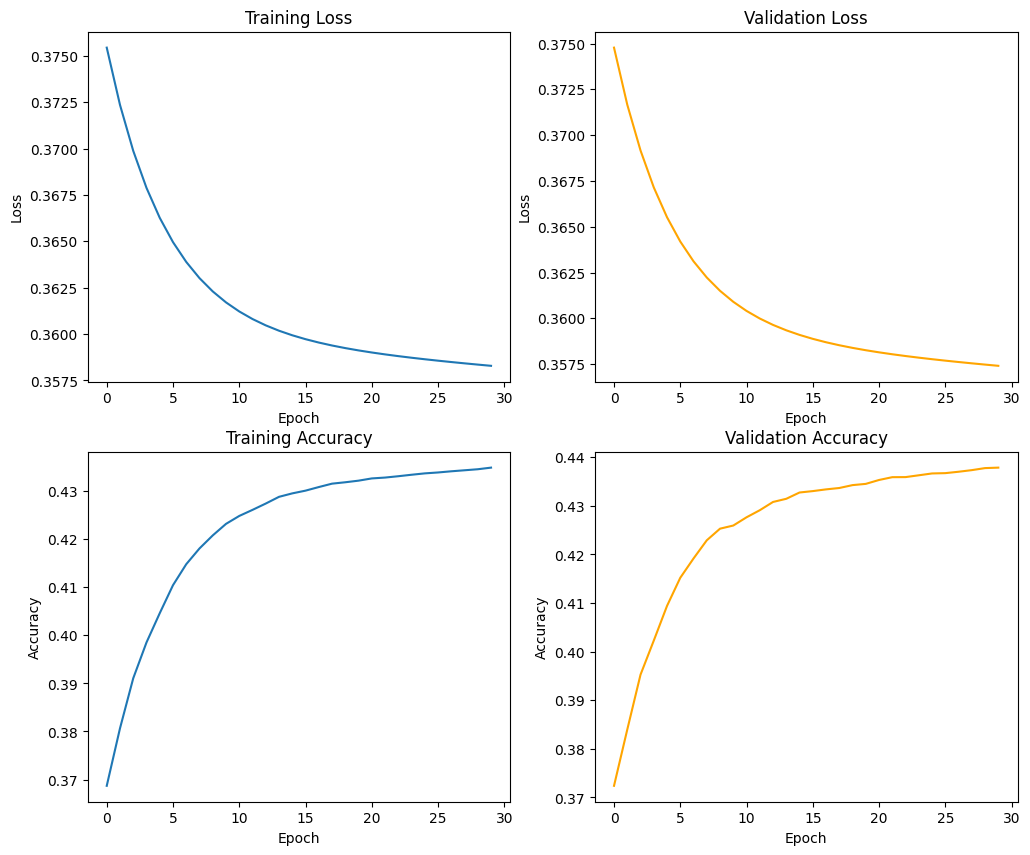

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')





val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set')
print(f"\tAccuracy - Validation: {val_set_acc}")
print(f"\tAccuracy - Test: {test_set_acc}")